In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [2]:
### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Arg-Met_04-25-22_norm.xlsx', sheet_name=None)
annotation_df = pd.read_excel('annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        if 'Aspartate' in k:
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Theoretical Amt', 'Filename', 'Type', 'RT', 'Sample ID'], axis=1)
        else:
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Theoretical Amt', 'Filename', 'Type', 'RT', 'Sample ID'], axis=1)


In [3]:
# Find a store the deviation from the mean:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'ISTD Response', 'Area'], axis=1)
for nam in metab_names_mes:
    if not 'Metformin' in nam:
        df[nam] = metab_dict_mes[nam]['Response Ratio'].values

# Normalize to 15 min:
df_norm = copy.deepcopy(df)
AA_cols = ['Alanine pos',
       'Arginine pos', 'Asparagine pos', 'Aspartate neg', 'Glutamate neg',
       'Glutamine pos', 'Glycine neg', 'Isoleucine pos', 'Leucine pos',
       'Lysine pos', 'Methionine pos', 'Phenylalanine pos', 'Proline pos',
       'Serine neg', 'Threonine neg', 'Tryptophan pos', 'Tyrosine pos',
       'Valine pos']

mask_drug = (df_norm['Drug'] == 'Rotenone')
mask_norm = (df_norm['Time'] == 0) & mask_drug
df_norm.loc[mask_drug, AA_cols] = np.divide(df_norm.loc[mask_drug, AA_cols].values, df_norm.loc[mask_norm, AA_cols].values)

mask_drug = (df_norm['Drug'] == 'Metformin')
mask_norm = (df_norm['Time'] == 0) & mask_drug
df_norm.loc[mask_drug, AA_cols] = np.divide(df_norm.loc[mask_drug, AA_cols].values, df_norm.loc[mask_norm, AA_cols].values)

# Flatten for plotting:
df_flat = pd.melt(df, id_vars=['Sample_name', 'Time', 'Drug']).rename(columns={'variable': 'Amino acid', 'value': 'Response'})
df_flat_norm = pd.melt(df_norm, id_vars=['Sample_name', 'Time', 'Drug']).rename(columns={'variable': 'Amino acid', 'value': 'Response'})

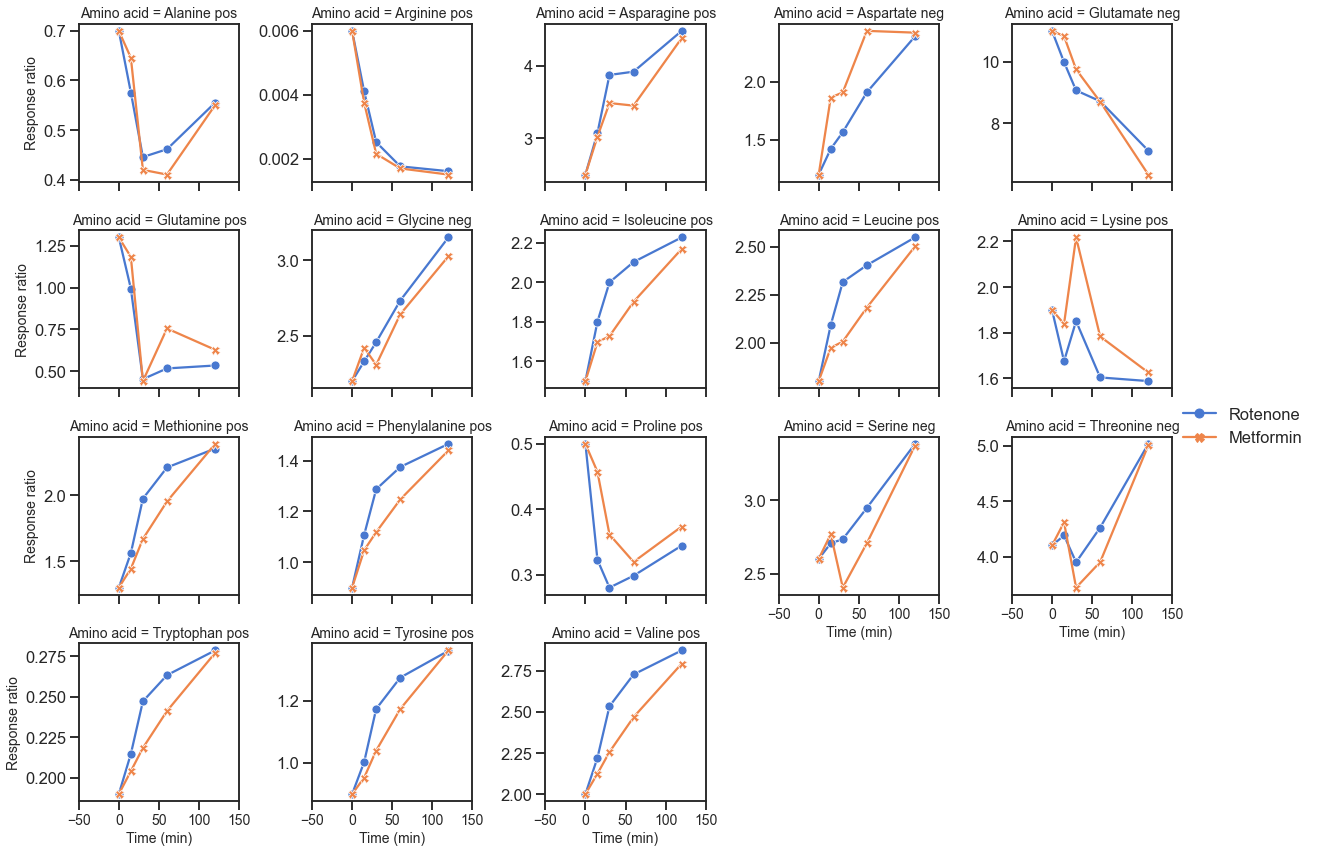

In [4]:
sns_fig = sns.FacetGrid(df_flat, col='Amino acid', height=3, aspect=1.1, col_wrap=5, despine=False, sharey=False)
sns_fig.map_dataframe(sns.lineplot, x='Time', y='Response', hue='Drug', style='Drug', markers=True, dashes=False)
sns_fig.set_axis_labels('Time (min)', 'Response ratio', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()
#sns_fig.savefig('plots/AA_acid-hydrolysis-stability.pdf', bbox_inches='tight')

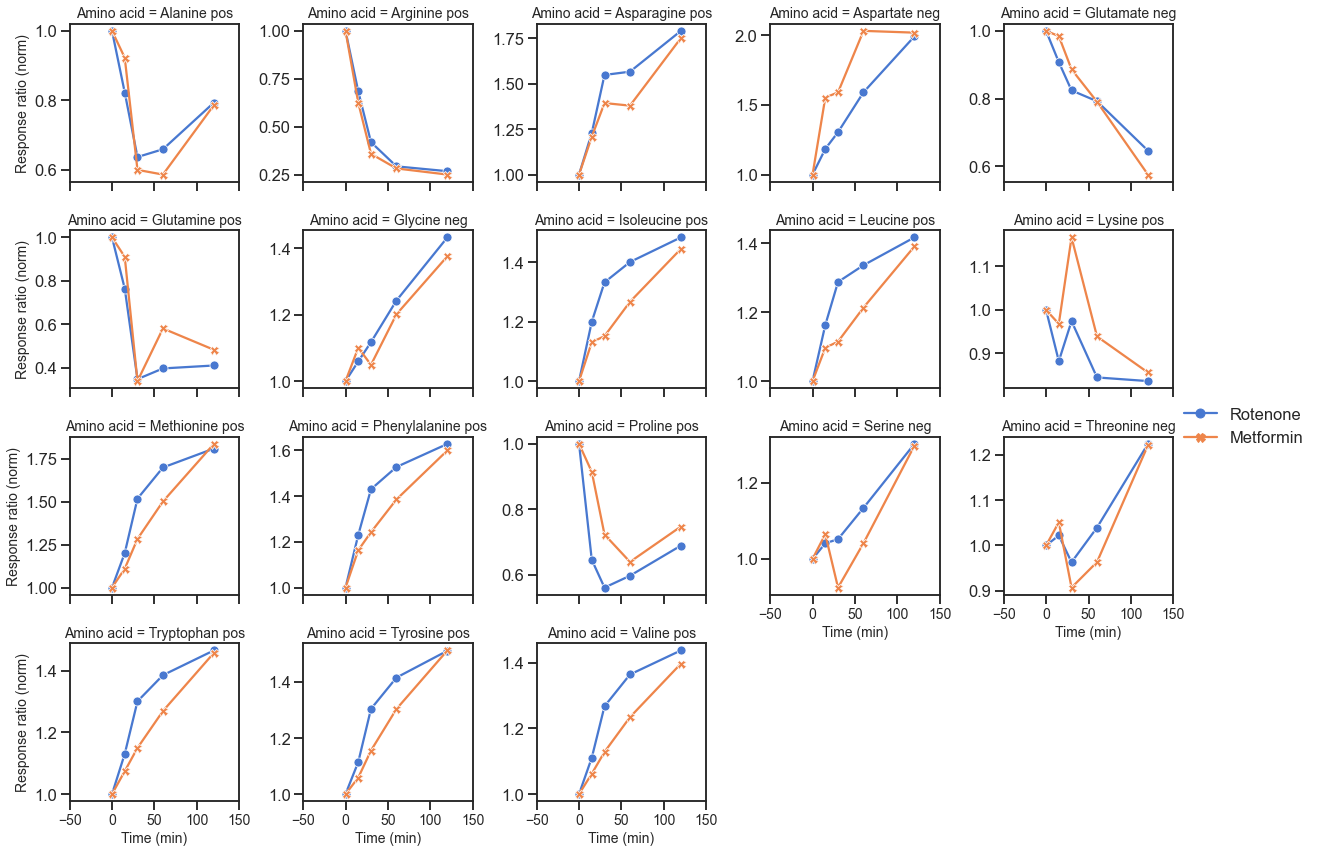

In [5]:
sns_fig = sns.FacetGrid(df_flat_norm, col='Amino acid', height=3, aspect=1.1, col_wrap=5, despine=False, sharey=False)
sns_fig.map_dataframe(sns.lineplot, x='Time', y='Response', hue='Drug', style='Drug', markers=True, dashes=False)
sns_fig.set_axis_labels('Time (min)', 'Response ratio (norm)', size=14)
sns_fig.set_xticklabels(size=14)
sns_fig.set_titles(size=14)
sns_fig.add_legend()